In [1]:
# Cell A — 导入 & 通用函数

import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Sigmoid 与带 L2 正则的 Logistic 损失
def sigmoid(z): return 1/(1+np.exp(-z))
def compute_loss(w, b, X, y, l2=1e-4):
    N = len(y)
    p = sigmoid(X.dot(w) + b)
    eps = 1e-12
    loss = - (y*np.log(p+eps) + (1-y)*np.log(1-p+eps)).mean()
    return loss + 0.5*l2*np.sum(w**2)

# GD：每轮一次全量梯度
def train_gd(X,y,Xt,yt, epochs, lr=1e-2, l2=1e-4):
    N,D = X.shape
    w, b = np.zeros(D), 0.0
    tr, te, _ = [], [], []
    t0 = time.time()
    for ep in range(epochs):
        # 梯度下降一步
        p  = sigmoid(X.dot(w)+b)
        gw = X.T.dot(p-y)/N + l2*w
        gb = (p-y).mean()
        w -= lr*gw; b -= lr*gb
        # 统计
        tr.append(compute_loss(w,b,X,y,l2))
        te.append(compute_loss(w,b,Xt,yt,l2))
    return np.array(tr), np.array(te), time.time()-t0

# SGD：每轮遍历一次随机梯度
def train_sgd(X,y,Xt,yt, epochs, lr=1e-3, l2=1e-4):
    N,D = X.shape
    w, b = np.zeros(D), 0.0
    tr, te = [], []
    t0 = time.time()
    for ep in range(epochs):
        perm = np.random.permutation(N)
        for i in perm:
            xi, yi = X[i], y[i]
            pi = sigmoid(xi.dot(w)+b)
            gw = xi*(pi-yi) + l2*w
            gb = (pi-yi)
            w -= lr*gw; b -= lr*gb
        tr.append(compute_loss(w,b,X,y,l2))
        te.append(compute_loss(w,b,Xt,yt,l2))
    return np.array(tr), np.array(te), time.time()-t0

# SAGA：方差消除随机梯度
def train_saga(X,y,Xt,yt, epochs, lr=1e-2, l2=1e-4):
    N,D = X.shape
    w, b = np.zeros(D), 0.0
    table = np.zeros((N,D+1))
    tr, te = [], []
    t0 = time.time()
    for ep in range(epochs):
        perm = np.random.permutation(N)
        mean_tbl = table.mean(axis=0)
        for i in perm:
            xi, yi = X[i], y[i]
            pi = sigmoid(xi.dot(w)+b)
            gw = xi*(pi-yi) + l2*w
            gb = (pi-yi)
            gi = np.concatenate([gw, [gb]])
            # SAGA 更新
            gest = gi - table[i] + mean_tbl
            w -= lr*gest[:D]; b -= lr*gest[D]
            table[i] = gi
            mean_tbl = mean_tbl + (gi - table[i])/(N)  # 在线更新 mean_tbl
        tr.append(compute_loss(w,b,X,y,l2))
        te.append(compute_loss(w,b,Xt,yt,l2))
    return np.array(tr), np.array(te), time.time()-t0


In [2]:
# Cell B — 对比 n=1_000 与 n=10_000
results = {}
for n in [1_000, 10_000]:
    # 1) 生成数据并划分
    X, y = make_classification(n_samples=n, n_features=20,
                               n_informative=15, n_redundant=5,
                               flip_y=0.01, class_sep=1.2,
                               random_state=0)
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=0
    )
    # 2) 训练并记录
    tr_obj = {}; te_risk = {}; times = {}
    for name, fn in [("GD", train_gd), ("SGD", train_sgd), ("SAGA", train_saga)]:
        tr, te, tm = fn(X_tr, y_tr, X_te, y_te, epochs=50)
        tr_obj[name], te_risk[name], times[name] = tr, te, tm
    results[n] = (tr_obj, te_risk, times)


C:\Users\Eugen_LNCantientropy\AppData\Local\Temp\ipykernel_84656\2212524476.py:10: RuntimeWarning: invalid value encountered in log10
  np.log10(tr - Fstar + 1e-12), label=name


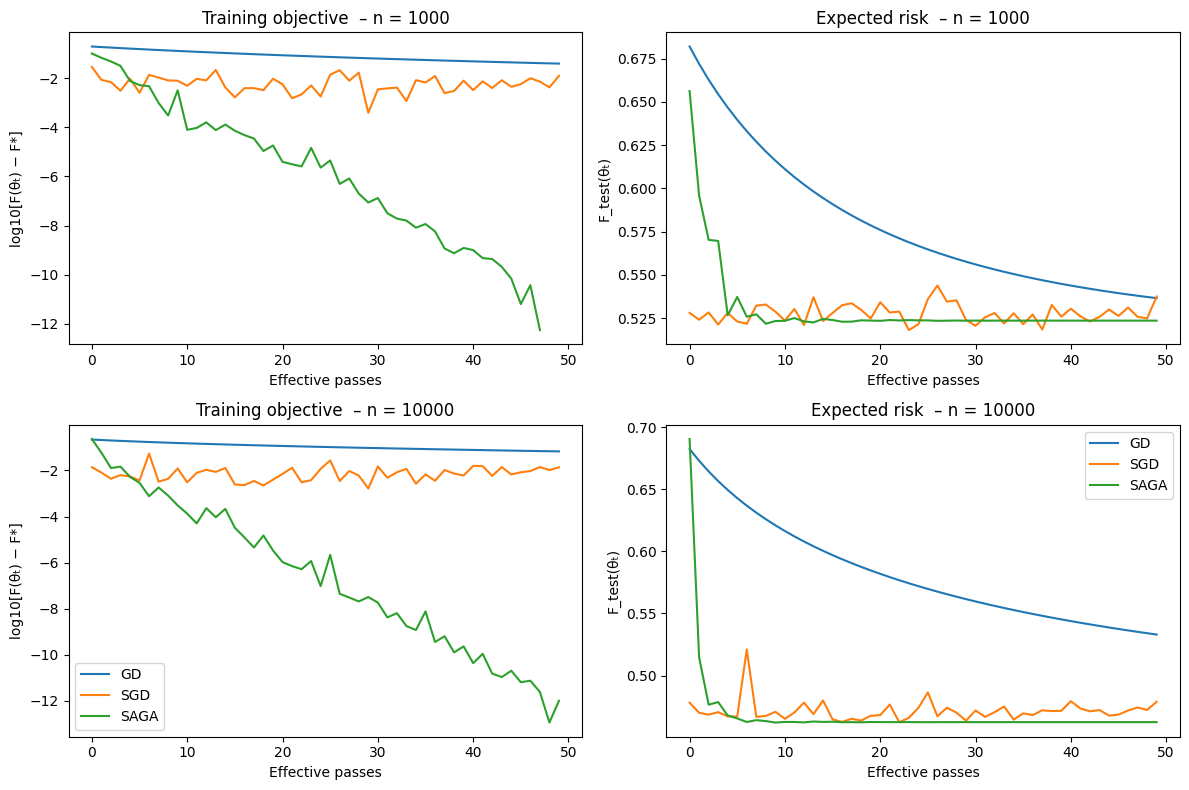

In [8]:
# Cell C — 绘图
fig, axes = plt.subplots(2,2, figsize=(12,8))
for i, n in enumerate([1_000, 10_000]):
    tr_obj, te_risk, _ = results[n]
    # 训练目标 -- log10(F(θ_t)-F*)
    # 取所有方法的最小训练值做 F* 近似
    Fstar = min(tr_obj[name][-1] for name in tr_obj)
    for name, tr in tr_obj.items():
        axes[i,0].plot(
            np.log10(tr - Fstar + 1e-12), label=name
        )
    axes[i,0].set_title(f"Training objective  – n = {n}")
    axes[i,0].set_xlabel("Effective passes")
    axes[i,0].set_ylabel("log10[F(θₜ) − F*]")
    if i==1: axes[i,0].legend()

    # 测试风险曲线
    for name, te in te_risk.items():
        axes[i,1].plot(te, label=name)
    axes[i,1].set_title(f"Expected risk  – n = {n}")
    axes[i,1].set_xlabel("Effective passes")
    axes[i,1].set_ylabel("F_test(θₜ)")
    if i==1: axes[i,1].legend()
plt.savefig("ls.png", dpi=300, bbox_inches="tight")
plt.tight_layout(); plt.show()


In [4]:
# Cell D — 打印耗时
for n in [1_000, 10_000]:
    _,_, times = results[n]
    print(f"n = {n}: ", end="")
    for name, t in times.items():
        print(f"{name} {t:.1f}s", end="    ")
    print()


n = 1000: GD 0.0s    SGD 0.2s    SAGA 0.4s    
n = 10000: GD 0.0s    SGD 1.8s    SAGA 3.2s    


In [5]:
# Cell E — 执行所有算法并收集结果

epochs = 50
res = {}
for name, fn in [("GD", train_gd),
                 ("SGD", train_sgd),
                 ("SAGA", train_saga)]:
    print(f"Running {name}...")
    tr, te, tm = fn(X_tr, y_tr, X_te, y_te, epochs)
    res[name] = (tr, te, tm)


Running GD...
Running SGD...
Running SAGA...


C:\Users\Eugen_LNCantientropy\AppData\Local\Temp\ipykernel_84656\3477367310.py:11: RuntimeWarning: invalid value encountered in log10
  plt.plot(epochs, np.log10(tr - Fstar + 1e-12), label=name)


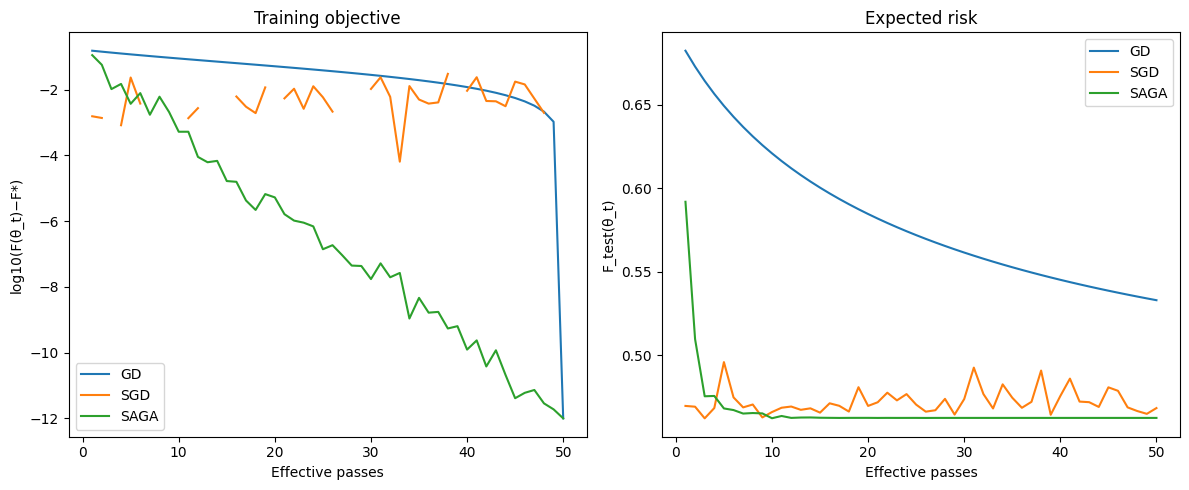

In [6]:
# Cell F — 绘制训练目标 & 期望风险

epochs = np.arange(1, epochs+1)
plt.figure(figsize=(12,5))

# 左：Training objective difference (in log10)
plt.subplot(1,2,1)
for name,(tr,_,_) in res.items():
    # 近似 F* = 最终训练目标
    Fstar = tr[-1]
    plt.plot(epochs, np.log10(tr - Fstar + 1e-12), label=name)
plt.xlabel("Effective passes"); plt.ylabel("log10(F(θ_t)−F*)")
plt.legend(); plt.title("Training objective")

# 右：Expected test risk
plt.subplot(1,2,2)
for name,(_,te,_) in res.items():
    plt.plot(epochs, te, label=name)
plt.xlabel("Effective passes"); plt.ylabel("F_test(θ_t)")
plt.legend(); plt.title("Expected risk")

plt.tight_layout(); plt.show()
